In [58]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

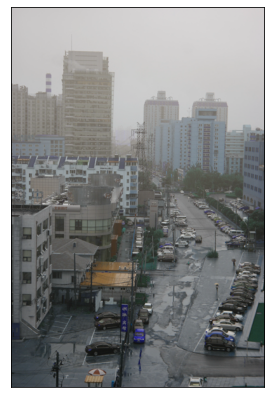

In [59]:
img = cv2.imread('data/source.png')

height = img.shape[0]
width = img.shape[1]

plt.figure(figsize=(10,7))
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()

## 雾图形成模型
![1](image/work4/1.png)<br>
I(X)就是我们现在已经有的图像（待去雾的图像），J(x)是我们要恢复的无雾的图像，A是全球大气光成分， t(x)为透射率。
主要是求t(x)和A

### 获取暗通道

In [60]:
def DarkChannel(im, sz):
    b, g, r = cv2.split(im)
    dc = cv2.min(cv2.min(r, g), b);
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (sz, sz))
    dark = cv2.erode(dc, kernel)
    return dark

### 获取全球大气光成分A值

In [61]:
def AtmLight(im, dark):
    [h, w] = im.shape[:2]
    imsz = h * w
    numpx = int(max(math.floor(imsz / 1000), 1))
    darkvec = dark.reshape(imsz);
    imvec = im.reshape(imsz, 3);

    indices = darkvec.argsort();
    indices = indices[imsz - numpx::]

    atmsum = np.zeros([1, 3])
    for ind in range(1, numpx):
        atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

### 投射率估计

In [62]:
def TransmissionEstimate(im, A, sz):
    omega = 0.9;
    im3 = np.empty(im.shape, im.dtype);

    for ind in range(0, 3):
        im3[:, :, ind] = im[:, :, ind] / A[0, ind]

    transmission = 1 - omega * DarkChannel(im3, sz);
    return transmission

### 引导滤波

In [63]:
def Guidedfilter(im, p, r, eps):
    mean_I = cv2.boxFilter(im, cv2.CV_64F, (r, r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r));
    mean_Ip = cv2.boxFilter(im * p, cv2.CV_64F, (r, r));
    cov_Ip = mean_Ip - mean_I * mean_p;

    mean_II = cv2.boxFilter(im * im, cv2.CV_64F, (r, r));
    var_I = mean_II - mean_I * mean_I;

    a = cov_Ip / (var_I + eps);
    b = mean_p - a * mean_I;

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r));
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r));

    q = mean_a * im + mean_b;
    return q;

In [64]:
def TransmissionRefine(im, et):
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray) / 255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray, et, r, eps);

    return t;

### 去雾获得J值

In [65]:
def Recover(im, t, A, tx=0.1):
    res = np.empty(im.shape, im.dtype);
    t = cv2.max(t, tx);

    for ind in range(0, 3):
        res[:, :, ind] = (im[:, :, ind] - A[0, ind]) / t + A[0, ind]

    return res

In [66]:
I = img.astype('float64') / 255;
dark = DarkChannel(I, 15);
A = AtmLight(I, dark);
# 透射率估计
te = TransmissionEstimate(I, A, 15);
# 透射率微调
t = TransmissionRefine(img, te);
J = Recover(I, t, A, 0.3);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


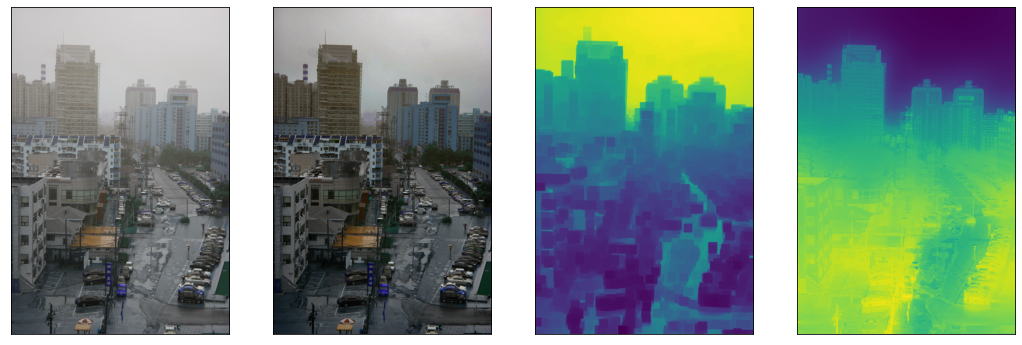

In [67]:
plt.figure(figsize=(18,12))
plt.subplot(141)
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.subplot(142)
plt.imshow(J)
plt.xticks([]), plt.yticks([])
plt.subplot(143)
plt.imshow(dark)
plt.xticks([]), plt.yticks([])
plt.subplot(144)
plt.imshow(t)
plt.xticks([]), plt.yticks([])
plt.show()